# Задание 1, Оксана Рудковская

Даны обращения клиентов в банк за 2018-2019гг., необходимо построить прогноз на первое полугодие 2020г.

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm


warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)
df = pd.read_excel("Задание прогноз.xlsx", sheet_name = 'Задание_1', usecols = "A:B")

In [2]:
y = df.set_index(['Дата'])
y = y[~y['Обращения'].isna()]
y.index = pd.DatetimeIndex(y.index.values, freq=y.index.inferred_freq)
y.head(5)

,Обращения
2018-01-01,4177.0
2018-01-02,8375.0
2018-01-03,13324.0
2018-01-04,15566.0
2018-01-05,16257.0


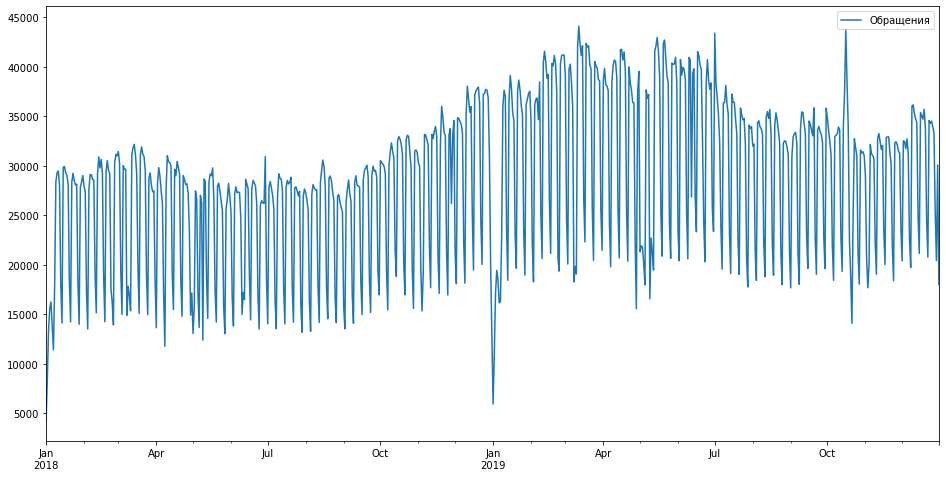

In [3]:
y.plot(figsize=(16, 8))
plt.show()

#### Сформируем тестовую и трейновую выборки. В качестве теста возьмем декабрь 2019года

In [4]:
y_train = y.iloc[:len(y)-31,:]
y_test = y.iloc[len(y)-31:,:]

####  Выделим во временном ряду трендовую, сезонную составляющую и шум

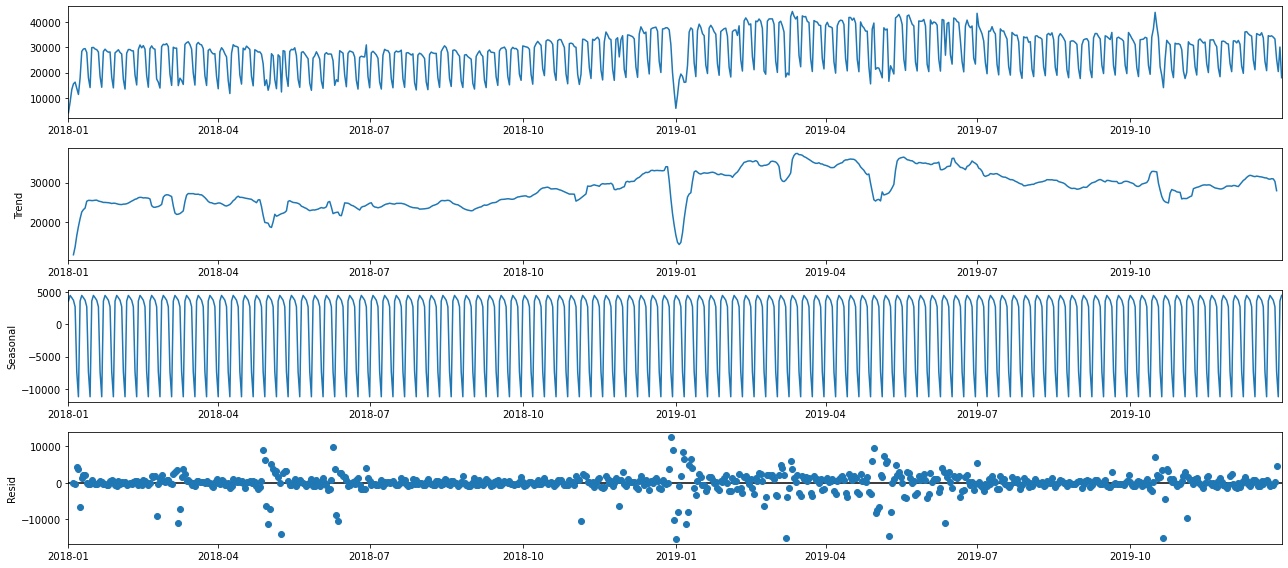

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

На визуализации видно, что присутствует сезонность (7 дней). Четкий тренд не отслеживается

In [6]:
# Параметры для подбора
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

### Строим модель SARIMA

In [7]:
# Подберем параметры для модели
best_aic = np.inf 
best_order = None
best_season_order = None
best_mdl = None

for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train, 
                                            order=param, 
                                            freq='D', 
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                           ).fit(trend='nc')
            tmp_aic = mod.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = param
                best_season_order = param_seasonal
                best_mdl = mod
        except: continue

print('aic: {:6.5f} | order: {} | season_order: {}'.format(best_aic, best_order,best_season_order))

 12%|██████████▌                                                                         | 1/8 [00:00<00:03,  1.92it/s]C:\Users\Oks\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:07<00:01,  1.04s/it]C:\Users\Oks\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.28s/it]

aic: 12943.57553 | order: (1, 1, 1) | season_order: (0, 1, 1, 7)


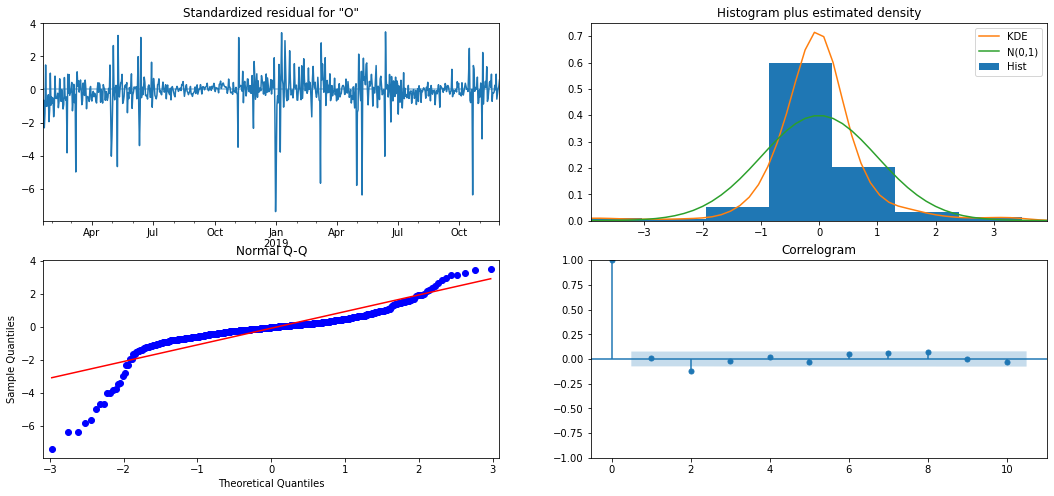

In [8]:
best_mdl.plot_diagnostics(figsize=(18, 8))
plt.show()

In [9]:
test = adfuller(best_mdl.resid)
print( 'adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print( 'единичных корней нет, ряд стационарен')

adf:  -20.893822184222657
p-value:  0.0
Critical values:  {'1%': -3.439766853257416, '5%': -2.8656956054873377, '10%': -2.5689829557089308}
единичных корней нет, ряд стационарен


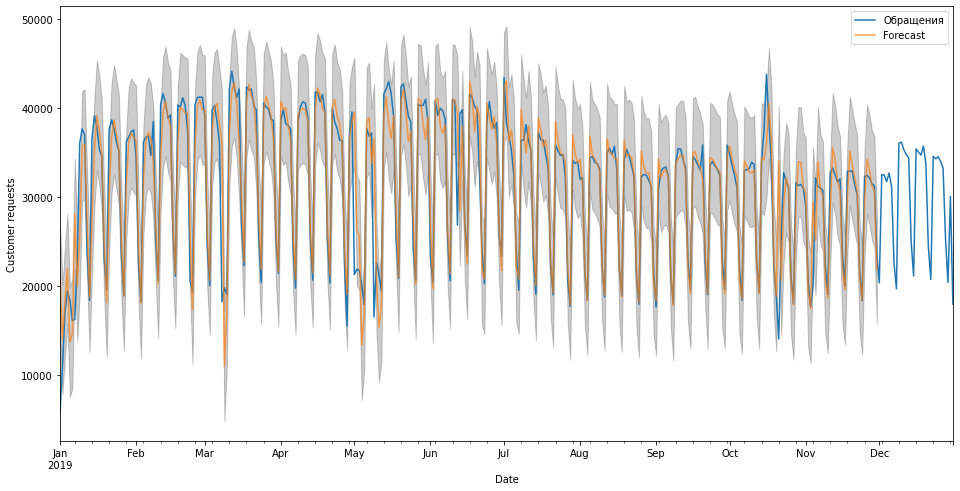

In [10]:
pred = best_mdl.get_prediction(start=pd.to_datetime('2019-01-01'),stop = pd.to_datetime('2020-12-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2019':].plot()
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
 pred_ci.iloc[:, 0],
 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Сustomer requests')
plt.legend()
plt.show()


In [11]:
# Средняя квадратичная ошибка
y_forecasted = pred.predicted_mean
y_truth = y['Обращения']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Средняя квадратичная ошибка {}'.format(round(np.sqrt(mse), 2)))

Средняя квадратичная ошибка 3364.01


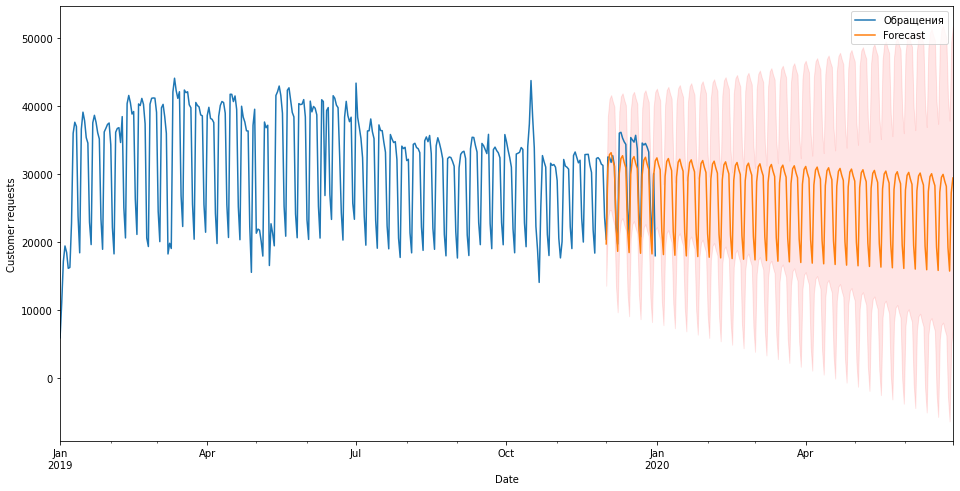

In [12]:
# Визуализирем предсказание с учетом тестовой выборки
pred_uc = best_mdl.get_forecast(steps=213)
pred_ci = pred_uc.conf_int()
ax = y['2019':].plot(label='observed', figsize=(16, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
 pred_ci.iloc[:, 0],
 pred_ci.iloc[:, 1], color='red', alpha=.10)
ax.set_xlabel('Date')
ax.set_ylabel('Сustomer requests')
plt.legend()
plt.show()

### Получился следующий прогноз на первое полугодие 2020г.

In [13]:
predict = pred_uc.predicted_mean['2020-01-01':].reset_index().rename(columns = {'index' : 'Date'})
predict

,Date,predicted_mean
0,2020-01-01,32400.053571
1,2020-01-02,31417.615338
2,2020-01-03,30638.627721
3,2020-01-04,21629.475849
4,2020-01-05,18176.021434
...,...,...
177,2020-06-26,28214.252751
178,2020-06-27,19205.103696
179,2020-06-28,15751.651260
180,2020-06-29,27265.079402
